## Model selection - Zillow dataset forecasting

In [318]:
reset -fs

In [319]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

%config InlineBackend.figure_format = 'svg'

### Read, visualize raw data

In [320]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [321]:
df = pd.read_csv('../data/zillow-california.csv', parse_dates=['Date'])

#### Quick n dirty visualizations

In [322]:
df

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate,MedianRentalPrice_AllHomes.California
0,2004-01-31,326752.55,5.02,7.9,NaN
1,2004-02-29,329501.50,4.94,7.8,NaN
2,2004-03-31,340125.45,4.74,7.8,NaN
3,2004-04-30,355329.50,5.16,7.5,NaN
4,2004-05-31,367818.15,5.64,7.3,NaN
...,...,...,...,...,...
159,2017-04-30,NaN,3.91,4.4,2600.0
160,2017-05-31,NaN,3.83,4.3,2650.0
161,2017-06-30,NaN,3.88,4.4,2675.0
162,2017-07-31,NaN,3.88,4.3,2695.0


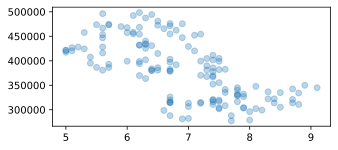

In [323]:
plt.figure(figsize=(5, 2.2))
plt.scatter(df['UnemploymentRate'], df['MedianSoldPrice_AllHomes.California'], alpha=0.3)
plt.show()

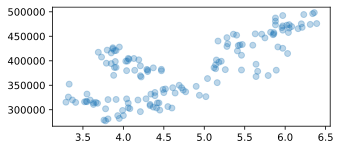

In [324]:
plt.figure(figsize=(5, 2.2))
plt.scatter(df['MedianMortageRate'], df['MedianSoldPrice_AllHomes.California'], alpha=0.3)
plt.show()

Correlations:
  - median mortgage rate
  - unemployment rate

In [325]:
sellprice = df['MedianSoldPrice_AllHomes.California']
sellprice.index = pd.DatetimeIndex(df['Date'])
sellprice.head()

Date
2004-01-31    326752.55
2004-02-29    329501.50
2004-03-31    340125.45
2004-04-30    355329.50
2004-05-31    367818.15
Name: MedianSoldPrice_AllHomes.California, dtype: float64

In [326]:
sellprice_not_na = sellprice[~sellprice.isna()]

#### Line, ACF plots

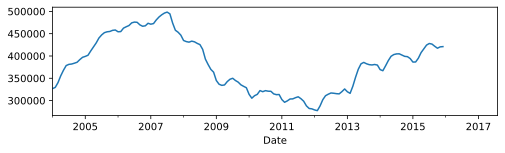

In [327]:
plt.figure(figsize=(8, 2))
sellprice.plot()
# plt.xticks(rotation=45)
plt.show()

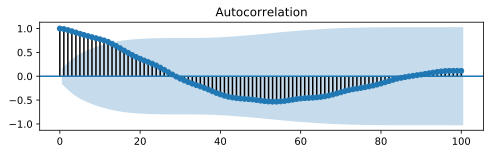

In [328]:
fig = plot_acf(sellprice_not_na, lags=100)
fig.set_size_inches(8, 2)
plt.show()

### Differencing

#### 1-time trend differencing

In [329]:
sellprice_d1 = pd.Series(np.diff(sellprice_not_na.values, n=1),
                           index=sellprice_not_na.index[1:])

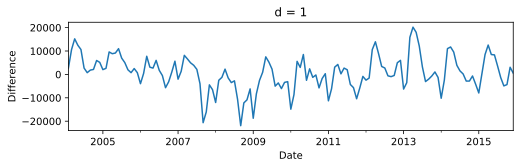

In [330]:
plt.figure(figsize=(8, 2))
sellprice_d1.plot()
plt.ylabel('Difference')
plt.title('d = 1')
plt.show()

In [331]:
adf_test(sellprice_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.687305
p-value                          0.437665
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


#### 2-time trend differencing

In [332]:
sellprice_d2 = pd.Series(np.diff(sellprice_not_na.values, n=2),
                           index=sellprice_not_na.index[2:])

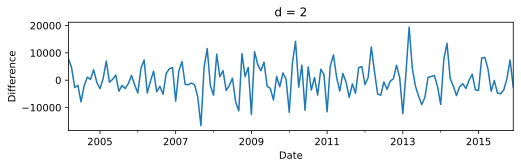

In [333]:
plt.figure(figsize=(8, 2))
sellprice_d2.plot()
plt.ylabel('Difference')
plt.title('d = 2')
plt.show()

In [334]:
adf_test(sellprice_d2)

Results of Dickey-Fuller Test:
Test Statistic                  -4.918846
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


#### 3-time trend differencing

In [335]:
sellprice_d3 = pd.Series(np.diff(sellprice_not_na.values, n=3),
                           index=sellprice_not_na.index[3:])

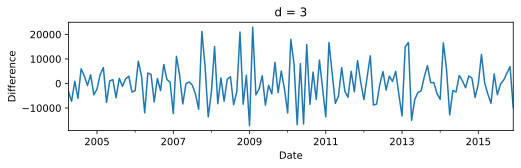

In [336]:
plt.figure(figsize=(8, 2))
sellprice_d3.plot()
plt.ylabel('Difference')
plt.title('d = 3')
plt.show()

In [337]:
adf_test(sellprice_d3)

Results of Dickey-Fuller Test:
Test Statistic                -7.368268e+00
p-value                        9.114125e-11
#Lags Used                     1.400000e+01
Number of Observations Used    1.260000e+02
Critical Value (1%)           -3.483346e+00
Critical Value (5%)           -2.884766e+00
Critical Value (10%)          -2.579156e+00
dtype: float64


#### 1-time seasonal differencing on 2-time trend differencing

There appears to be slight seasonality with lag 12, according to the 1-time differencing line plot.

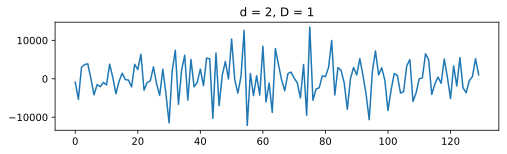

In [338]:
sellprice_d2_D1 = []
for i in range(12, len(sellprice_d2)):
    value = sellprice_d2[i] - sellprice_d2[i - 12]  # lag is 12 (seasonal lag is 1 year, or 12 months)
    sellprice_d2_D1.append(value)
plt.figure(figsize=(8, 2))
plt.title('d = 2, D = 1')
plt.plot(sellprice_d2_D1) 
plt.show()

In [339]:
adf_test(sellprice_d2_D1)

Results of Dickey-Fuller Test:
Test Statistic                  -5.149454
p-value                          0.000011
#Lags Used                      13.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


#### 2-time seasonal differencing on 2-time trend differencing

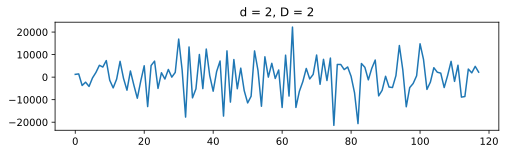

In [343]:
sellprice_d2_D2 = []
for i in range(12, len(sellprice_d2_D1)):
    value = sellprice_d2_D1[i] - sellprice_d2_D1[i - 12]  # lag is 12 (seasonal lag is 1 year, or 12 months)
    sellprice_d2_D2.append(value)
plt.figure(figsize=(8, 2))
plt.title('d = 2, D = 2')
plt.plot(sellprice_d2_D2) 
plt.show()

In [344]:
adf_test(sellprice_d2_D2)

Results of Dickey-Fuller Test:
Test Statistic                  -5.224150
p-value                          0.000008
#Lags Used                      13.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


## Model selection with Auto-ARIMA

### d = 2, D = 2

In [351]:
train_size = int(len(sellprice_not_na) * 0.80)
train, valid = sellprice_not_na[:train_size], sellprice_not_na[train_size:]
test = sellprice[sellprice.index >= pd.to_datetime('2016')]

In [352]:
model_d2_D2 = pm.auto_arima(train, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,  # seasonal lag = 12
                            start_P=0, seasonal=True,
                            d=2, D=2, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 2, 1, 12); AIC=1787.584, BIC=1800.027, Fit time=0.859 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 2, 0, 12); AIC=1858.671, BIC=1863.649, Fit time=0.019 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 2, 0, 12); AIC=1861.609, BIC=1871.563, Fit time=0.173 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 2, 1, 12); AIC=1784.863, BIC=1794.818, Fit time=0.690 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 2, 1, 12); AIC=1805.663, BIC=1818.106, Fit time=1.036 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 2, 0, 12); AIC=1860.015, BIC=1867.481, Fit time=0.072 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 2, 2, 12); AIC=1785.569, BIC=1798.012, Fit time=1.576 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 2, 2, 12); AIC=1812.440, BIC=1827.372, Fit time=1.923 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 2, 1, 12); AIC=1796.098, BIC=1803.564, Fit time=0.275 seconds
Fit ARIMA: order=(0, 2, 2) s

In [353]:
model_d2_D2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(0, 2, 1)x(0, 2, 1, 12)   Log Likelihood                -888.432
Date:                            Fri, 06 Dec 2019   AIC                           1784.863
Time:                                    16:57:47   BIC                           1794.818
Sample:                                         0   HQIC                          1788.876
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.7495     82.216      0.070      0.944    -155.390     166.889
ma.L1         -0.4513      0.098     -4.599      0.000      -0.644      -0.259
ma.S.L12      -0.9723      0.136     -7.153      0.000      -1.239      -0.706
sigma2      2.473e+07   2.89e-05   8.55e+11      0.000    2.47e+07    2.47e+07
===================================================================================
Ljung-Box (Q):                       49.75   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.14   Prob(JB):                         0.56
Heteroskedasticity (H):               1.95   Skew:                             0.21
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.39e+28. Standard errors may be unstable.
"""

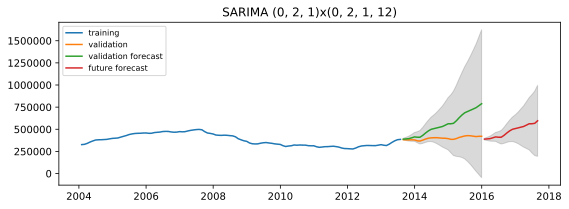

In [354]:
fc1, conf1 = model_d2_D2.predict(len(valid), return_conf_int=True, alpha=0.05)
fc2, conf2 = model_d2_D2.predict(len(test), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(fc1, index=valid.index)
fc_series2 = pd.Series(fc2, index=test.index)

lower_series1 = pd.Series(conf1[:, 0], index=valid.index)
upper_series1 = pd.Series(conf1[:, 1], index=valid.index)
lower_series2 = pd.Series(conf2[:, 0], index=test.index)
upper_series2 = pd.Series(conf2[:, 1], index=test.index)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(train, label='training')
plt.plot(valid, label='validation')
plt.plot(fc_series1, label='validation forecast')
plt.plot(fc_series2, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.15)

plt.title('SARIMA (0, 2, 1)x(0, 2, 1, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Evaluation

In [357]:
mse = ((fc_series1 - valid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

188279.65


### d = 1, D = 2

**Best so far**

In [358]:
train_size = int(len(sellprice_not_na) * 0.80)
train, valid = sellprice_not_na[:train_size], sellprice_not_na[train_size:]
test = sellprice[sellprice.index >= pd.to_datetime('2016')]

In [359]:
model_d1_D2 = pm.auto_arima(train, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,  # seasonal lag = 12
                            start_P=0, seasonal=True,
                            d=1, D=2, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=1807.452, BIC=1819.951, Fit time=0.922 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 2, 0, 12); AIC=1887.649, BIC=1892.649, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 2, 0, 12); AIC=1896.124, BIC=1906.124, Fit time=0.211 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=1841.415, BIC=1851.414, Fit time=0.171 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 1, 12); AIC=1825.971, BIC=1840.970, Fit time=0.447 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 0, 12); AIC=1894.700, BIC=1904.699, Fit time=0.256 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 2, 12); AIC=1826.015, BIC=1841.013, Fit time=0.948 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 2, 12); AIC=1825.577, BIC=1843.076, Fit time=2.504 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=1809.067, BIC=1824.066, Fit time=1.027 seconds
Fit ARIMA: order=(1, 1, 0) s

In [360]:
model_d1_D2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(0, 2, 1, 12)   Log Likelihood                -898.726
Date:                            Fri, 06 Dec 2019   AIC                           1807.452
Time:                                    16:58:26   BIC                           1819.951
Sample:                                         0   HQIC                          1812.493
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -149.9466    124.586     -1.204      0.229    -394.130      94.237
ar.L1          0.8166      0.126      6.467      0.000       0.569       1.064
ma.L1         -0.3133      0.193     -1.622      0.105      -0.692       0.065
ma.S.L12      -0.9983      0.165     -6.053      0.000      -1.322      -0.675
sigma2      2.817e+07   3.32e-06   8.47e+12      0.000    2.82e+07    2.82e+07
===================================================================================
Ljung-Box (Q):                       37.55   Jarque-Bera (JB):                 3.87
Prob(Q):                              0.58   Prob(JB):                         0.14
Heteroskedasticity (H):               2.11   Skew:                             0.41
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.79e+30. Standard errors may be unstable.
"""

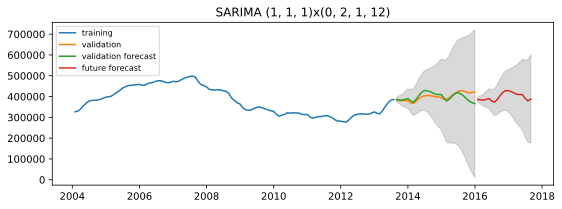

In [361]:
fc1, conf1 = model_d1_D2.predict(len(valid), return_conf_int=True, alpha=0.05)
fc2, conf2 = model_d1_D2.predict(len(test), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(fc1, index=valid.index)
fc_series2 = pd.Series(fc2, index=test.index)

lower_series1 = pd.Series(conf1[:, 0], index=valid.index)
upper_series1 = pd.Series(conf1[:, 1], index=valid.index)
lower_series2 = pd.Series(conf2[:, 0], index=test.index)
upper_series2 = pd.Series(conf2[:, 1], index=test.index)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(train, label='training')
plt.plot(valid, label='validation')
plt.plot(fc_series1, label='validation forecast')
plt.plot(fc_series2, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.15)

plt.title('SARIMA (1, 1, 1)x(0, 2, 1, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Evaluation

In [362]:
mse = ((fc_series1 - valid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

20606.54


### d = 1, D = 1

**Not good!**

In [259]:
train_size = int(len(sellprice_not_na) * 0.80)
train, valid = sellprice_not_na[:train_size], sellprice_not_na[train_size:]
test = sellprice[sellprice.index >= pd.to_datetime('2016')]

In [260]:
model_d1_D1 = pm.auto_arima(train, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,  # seasonal lag = 12
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2047.864, BIC=2060.989, Fit time=0.789 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2062.232, BIC=2067.482, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2079.005, BIC=2089.505, Fit time=0.096 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2065.258, BIC=2075.758, Fit time=0.093 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2051.274, BIC=2067.023, Fit time=0.647 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2042.957, BIC=2053.457, Fit time=0.252 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2064.025, BIC=2071.900, Fit time=0.029 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2048.069, BIC=2061.194, Fit time=0.274 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2078.034, BIC=2085.909, Fit time=0.033 seconds
Fit ARIMA: order=(1, 1, 2) s

In [261]:
model_d1_D1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 12)   Log Likelihood               -1017.478
Date:                            Mon, 02 Dec 2019   AIC                           2042.957
Time:                                    21:52:11   BIC                           2053.457
Sample:                                         0   HQIC                          2047.209
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     87.6254     42.449      2.064      0.039       4.426     170.825
ar.L1          1.0000      0.016     62.954      0.000       0.969       1.031
ma.L1         -0.9228      0.011    -87.649      0.000      -0.943      -0.902
sigma2      2.649e+07    6.8e-05   3.89e+11      0.000    2.65e+07    2.65e+07
===================================================================================
Ljung-Box (Q):                      121.61   Jarque-Bera (JB):                 4.10
Prob(Q):                              0.00   Prob(JB):                         0.13
Heteroskedasticity (H):               1.09   Skew:                             0.17
Prob(H) (two-sided):                  0.80   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.8e+27. Standard errors may be unstable.
"""

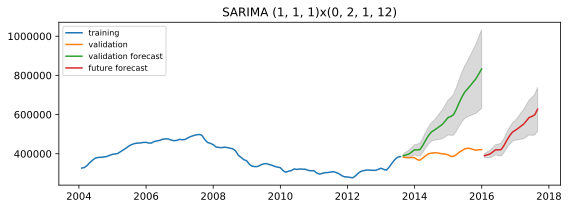

In [262]:
fc1, conf1 = model_d1_D1.predict(len(valid), return_conf_int=True, alpha=0.05)
fc2, conf2 = model_d1_D1.predict(len(test), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(fc1, index=valid.index)
fc_series2 = pd.Series(fc2, index=test.index)

lower_series1 = pd.Series(conf1[:, 0], index=valid.index)
upper_series1 = pd.Series(conf1[:, 1], index=valid.index)
lower_series2 = pd.Series(conf2[:, 0], index=test.index)
upper_series2 = pd.Series(conf2[:, 1], index=test.index)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(train, label='training')
plt.plot(valid, label='validation')
plt.plot(fc_series1, label='validation forecast')
plt.plot(fc_series2, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.15)

plt.title('SARIMA (1, 1, 1)x(0, 2, 1, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Evaluation

In [263]:
mse = ((fc_series - valid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

188279.65
